# SGA-PMX Demo

Skrypt przedstawia przykładową implementację algorytmu Simple Genetic Algorithm (SGA) z operatorem PMX i jego zastosowanie do rozwiązywania problemu komiwojażera (ang. Travelling Salesman Problem, TSP). Popularne instancje problemu TSP można znaleźć w bibliotece TSPLib [1]. Skrypt skupia się na rozwiązywaniu instancji BERLIN52, w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu, a może też i operatorów ewolucyjnych.

Literatura:

[1] TSPLIB, http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
from functools import partial, reduce
from collections import Counter

def compose(*funcs):
    return reduce(lambda f, g: lambda *args: f(*g(*args)), funcs, lambda *args: args)

%matplotlib inline

## Input data

In [0]:
# BERLIN52
n = 52


def distance_matrix(n, coords):
    A = np.empty((n, n), dtype=np.float64)
    for i in range(n):
        for j in range(n):
            A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
    return A


kroa100_coords = np.array([[1380.,  939.],       [2848.,   96.],       [3510., 1671.],       [ 457.,  334.],       [3888.,  666.],       [ 984.,  965.],       [2721., 1482.],       [1286.,  525.],       [2716., 1432.],       [ 738., 1325.],       [1251., 1832.],       [2728., 1698.],       [3815.,  169.],       [3683., 1533.],       [1247., 1945.],       [ 123.,  862.],       [1234., 1946.],       [ 252., 1240.],       [ 611.,  673.],       [2576., 1676.],       [ 928., 1700.],       [  53.,  857.],       [1807., 1711.],       [ 274., 1420.],       [2574.,  946.],       [ 178.,   24.],       [2678., 1825.],       [1795.,  962.],       [3384., 1498.],       [3520., 1079.],       [1256.,   61.],       [1424., 1728.],       [3913.,  192.],       [3085., 1528.],       [2573., 1969.],       [ 463., 1670.],       [3875.,  598.],       [ 298., 1513.],       [3479.,  821.],       [2542.,  236.],       [3955., 1743.],       [1323.,  280.],       [3447., 1830.],       [2936.,  337.],       [1621., 1830.],       [3373., 1646.],       [1393., 1368.],       [3874., 1318.],       [ 938.,  955.],       [3022.,  474.],       [2482., 1183.],       [3854.,  923.],       [ 376.,  825.],       [2519.,  135.],       [2945., 1622.],       [ 953.,  268.],       [2628., 1479.],       [2097.,  981.],       [ 890., 1846.],       [2139., 1806.],       [2421., 1007.],       [2290., 1810.],       [1115., 1052.],       [2588.,  302.],       [ 327.,  265.],       [ 241.,  341.],       [1917.,  687.],       [2991.,  792.],       [2573.,  599.],       [  19.,  674.],       [3911., 1673.],       [ 872., 1559.],       [2863.,  558.],       [ 929., 1766.],       [ 839.,  620.],       [3893.,  102.],       [2178., 1619.],       [3822.,  899.],       [ 378., 1048.],       [1178.,  100.],       [2599.,  901.],       [3416.,  143.],       [2961., 1605.],       [ 611., 1384.],       [3113.,  885.],       [2597., 1830.],       [2586., 1286.],       [ 161.,  906.],       [1429.,  134.],       [ 742., 1025.],       [1625., 1651.],       [1187.,  706.],       [1787., 1009.],       [  22.,  987.],       [3640.,   43.],       [3756.,  882.],       [ 776.,  392.],       [1724., 1642.],       [ 198., 1810.],       [3950., 1558.]])
kroa100_distance = distance_matrix(100, kroa100_coords)

kroa150_coords = np.array([[1380.,  939.],       [2848.,   96.],       [3510., 1671.],       [ 457.,  334.],       [3888.,  666.],       [ 984.,  965.],       [2721., 1482.],       [1286.,  525.],       [2716., 1432.],       [ 738., 1325.],       [1251., 1832.],       [2728., 1698.],       [3815.,  169.],       [3683., 1533.],       [1247., 1945.],       [ 123.,  862.],       [1234., 1946.],       [ 252., 1240.],       [ 611.,  673.],       [2576., 1676.],       [ 928., 1700.],       [  53.,  857.],       [1807., 1711.],       [ 274., 1420.],       [2574.,  946.],       [ 178.,   24.],       [2678., 1825.],       [1795.,  962.],       [3384., 1498.],       [3520., 1079.],       [1256.,   61.],       [1424., 1728.],       [3913.,  192.],       [3085., 1528.],       [2573., 1969.],       [ 463., 1670.],       [3875.,  598.],       [ 298., 1513.],       [3479.,  821.],       [2542.,  236.],       [3955., 1743.],       [1323.,  280.],       [3447., 1830.],       [2936.,  337.],       [1621., 1830.],       [3373., 1646.],       [1393., 1368.],       [3874., 1318.],       [ 938.,  955.],       [3022.,  474.],       [2482., 1183.],       [3854.,  923.],       [ 376.,  825.],       [2519.,  135.],       [2945., 1622.],       [ 953.,  268.],       [2628., 1479.],       [2097.,  981.],       [ 890., 1846.],       [2139., 1806.],       [2421., 1007.],       [2290., 1810.],       [1115., 1052.],       [2588.,  302.],       [ 327.,  265.],       [ 241.,  341.],       [1917.,  687.],       [2991.,  792.],       [2573.,  599.],       [  19.,  674.],       [3911., 1673.],       [ 872., 1559.],       [2863.,  558.],       [ 929., 1766.],       [ 839.,  620.],       [3893.,  102.],       [2178., 1619.],       [3822.,  899.],       [ 378., 1048.],       [1178.,  100.],       [2599.,  901.],       [3416.,  143.],       [2961., 1605.],       [ 611., 1384.],       [3113.,  885.],       [2597., 1830.],       [2586., 1286.],       [ 161.,  906.],       [1429.,  134.],       [ 742., 1025.],       [1625., 1651.],       [1187.,  706.],       [1787., 1009.],       [  22.,  987.],       [3640.,   43.],       [3756.,  882.],       [ 776.,  392.],       [1724., 1642.],       [ 198., 1810.],       [3950., 1558.],       [3477.,  949.],       [  91., 1732.],       [3972.,  329.],       [ 198., 1632.],       [1806.,  733.],       [ 538., 1023.],       [3430., 1088.],       [2186.,  766.],       [1513., 1646.],       [2143., 1611.],       [  53., 1657.],       [3404., 1307.],       [1034., 1344.],       [2823.,  376.],       [3104., 1931.],       [3232.,  324.],       [2790., 1457.],       [ 374.,    9.],       [ 741.,  146.],       [3083., 1938.],       [3502., 1067.],       [1280.,  237.],       [3326., 1846.],       [ 217.,   38.],       [2503., 1172.],       [3527.,   41.],       [ 739., 1850.],       [3548., 1999.],       [  48.,  154.],       [1419.,  872.],       [1689., 1223.],       [3468., 1404.],       [1628.,  253.],       [ 382.,  872.],       [3029., 1242.],       [3646., 1758.],       [ 285., 1029.],       [1782.,   93.],       [1067.,  371.],       [2849., 1214.],       [ 920., 1835.],       [1741.,  712.],       [ 876.,  220.],       [2753.,  283.],       [2609., 1286.],       [3941.,  258.],       [3613.,  523.],       [1754.,  559.],       [2916., 1724.],       [2445., 1820.]])
kroa150_distance = distance_matrix(150, kroa150_coords)

kroa200_coords = np.array([[1357., 1905.],       [2650.,  802.],       [1774.,  107.],       [1307.,  964.],       [3806.,  746.],       [2687., 1353.],       [  43., 1957.],       [3092., 1668.],       [ 185., 1542.],       [ 834.,  629.],       [  40.,  462.],       [1183., 1391.],       [2048., 1628.],       [1097.,  643.],       [1838., 1732.],       [ 234., 1118.],       [3314., 1881.],       [ 737., 1285.],       [ 779.,  777.],       [2312., 1949.],       [2576.,  189.],       [3078., 1541.],       [2781.,  478.],       [ 705., 1812.],       [3409., 1917.],       [ 323., 1714.],       [1660., 1556.],       [3729., 1188.],       [ 693., 1383.],       [2361.,  640.],       [2433., 1538.],       [ 554., 1825.],       [ 913.,  317.],       [3586., 1909.],       [2636.,  727.],       [1000.,  457.],       [ 482., 1337.],       [3704., 1082.],       [3635., 1174.],       [1362., 1526.],       [2049.,  417.],       [2552., 1909.],       [3939.,  640.],       [ 219.,  898.],       [ 812.,  351.],       [ 901., 1552.],       [2513., 1572.],       [ 242.,  584.],       [ 826., 1226.],       [3278.,  799.],       [  86., 1065.],       [  14.,  454.],       [1327., 1893.],       [2773., 1286.],       [2469., 1838.],       [3835.,  963.],       [1031.,  428.],       [3853., 1712.],       [1868.,  197.],       [1544.,  863.],       [ 457., 1607.],       [3174., 1064.],       [ 192., 1004.],       [2318., 1925.],       [2232., 1374.],       [ 396.,  828.],       [2365., 1649.],       [2499.,  658.],       [1410.,  307.],       [2990.,  214.],       [3646., 1018.],       [3394., 1028.],       [1779.,   90.],       [1058.,  372.],       [2933., 1459.],       [3099.,  173.],       [2178.,  978.],       [ 138., 1610.],       [2082., 1753.],       [2302., 1127.],       [ 805.,  272.],       [  22., 1617.],       [3213., 1085.],       [  99.,  536.],       [1533., 1780.],       [3564.,  676.],       [  29.,    6.],       [3808., 1375.],       [2221.,  291.],       [3499., 1885.],       [3124.,  408.],       [ 781.,  671.],       [1027., 1041.],       [3249.,  378.],       [3297.,  491.],       [ 213.,  220.],       [ 721.,  186.],       [3736., 1542.],       [ 868.,  731.],       [ 960.,  303.],       [1380.,  939.],       [2848.,   96.],       [3510., 1671.],       [ 457.,  334.],       [3888.,  666.],       [ 984.,  965.],       [2721., 1482.],       [1286.,  525.],       [2716., 1432.],       [ 738., 1325.],       [1251., 1832.],       [2728., 1698.],       [3815.,  169.],       [3683., 1533.],       [1247., 1945.],       [ 123.,  862.],       [1234., 1946.],       [ 252., 1240.],       [ 611.,  673.],       [2576., 1676.],       [ 928., 1700.],       [  53.,  857.],       [1807., 1711.],       [ 274., 1420.],       [2574.,  946.],       [ 178.,   24.],       [2678., 1825.],       [1795.,  962.],       [3384., 1498.],       [3520., 1079.],       [1256.,   61.],       [1424., 1728.],       [3913.,  192.],       [3085., 1528.],       [2573., 1969.],       [ 463., 1670.],       [3875.,  598.],       [ 298., 1513.],       [3479.,  821.],       [2542.,  236.],       [3955., 1743.],       [1323.,  280.],       [3447., 1830.],       [2936.,  337.],       [1621., 1830.],       [3373., 1646.],       [1393., 1368.],       [3874., 1318.],       [ 938.,  955.],       [3022.,  474.],       [2482., 1183.],       [3854.,  923.],       [ 376.,  825.],       [2519.,  135.],       [2945., 1622.],       [ 953.,  268.],       [2628., 1479.],       [2097.,  981.],       [ 890., 1846.],       [2139., 1806.],       [2421., 1007.],       [2290., 1810.],       [1115., 1052.],       [2588.,  302.],       [ 327.,  265.],       [ 241.,  341.],       [1917.,  687.],       [2991.,  792.],       [2573.,  599.],       [  19.,  674.],       [3911., 1673.],       [ 872., 1559.],       [2863.,  558.],       [ 929., 1766.],       [ 839.,  620.],       [3893.,  102.],       [2178., 1619.],       [3822.,  899.],       [ 378., 1048.],       [1178.,  100.],       [2599.,  901.],       [3416.,  143.],       [2961., 1605.],       [ 611., 1384.],       [3113.,  885.],       [2597., 1830.],       [2586., 1286.],       [ 161.,  906.],       [1429.,  134.],       [ 742., 1025.],       [1625., 1651.],       [1187.,  706.],       [1787., 1009.],       [  22.,  987.],       [3640.,   43.],       [3756.,  882.],       [ 776.,  392.],       [1724., 1642.],       [ 198., 1810.],       [3950., 1558.]])
kroa200_distance = distance_matrix(200, kroa200_coords)


datasets = {
    'kroA100': kroa100_coords,
    'kroA100_distance': kroa100_distance,
    'kroA150': kroa150_coords,
    'kroA150_distance': kroa150_distance,
    'kroA200': kroa200_coords,    
    'kroA200_distance': kroa200_distance,    
}


def load_berlin52(n):
    coords = np.array([565.0, 575.0, 25.0, 185.0, 345.0, 750.0, 945.0, 685.0, 845.0, 655.0, 880.0, 660.0, 25.0, 230.0, 525.0, 1000.0, 580.0, 1175.0, 650.0, 1130.0, 1605.0, 620.0, 1220.0, 580.0, 1465.0, 200.0, 1530.0, 5.0, 845.0, 680.0, 725.0, 370.0, 145.0, 665.0, 415.0, 635.0, 510.0, 875.0, 560.0, 365.0, 300.0, 465.0, 520.0, 585.0, 480.0, 415.0, 835.0, 625.0, 975.0, 580.0, 1215.0, 245.0, 1320.0, 315.0, 1250.0, 400.0, 660.0, 180.0, 410.0, 250.0, 420.0, 555.0, 575.0, 665.0, 1150.0, 1160.0, 700.0, 580.0, 685.0, 595.0, 685.0, 610.0, 770.0, 610.0, 795.0, 645.0, 720.0, 635.0, 760.0, 650.0, 475.0, 960.0, 95.0, 260.0, 875.0, 920.0, 700.0, 500.0, 555.0, 815.0, 830.0, 485.0, 1170.0, 65.0, 830.0, 610.0, 605.0, 625.0, 595.0, 360.0, 1340.0, 725.0, 1740.0, 245.0])
    coords = coords.reshape(n, 2)

    A = distance_matrix(52, coords)

    p = [0, 48, 31, 44, 18, 40,  7,  8,  9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24,  3,  5, 14,  4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29,  1,  6, 41, 20, 16,  2, 17, 30, 21]
    return A, coords, p


def load_kroa(n):
    assert(n in [100, 150, 200])
    
    return datasets[f'kroA{n}_distance']
    
    with open(f'data/kroA{n}.coords', 'r') as f:
        data = f.read().splitlines()
    
    coords = list(map(lambda x: x.split(' '), data))
    coords = np.array(coords, dtype=np.float64)
    return distance_matrix(n, coords)


def load_bays29():
    
    with open('bays29.matrix', 'r') as f:
        data = f.read().splitlines()    
    return np.array(list(map(lambda l: list(filter(lambda l: l!= '', l.split(' '))), data)), dtype=np.float64)


A, coords, p = load_berlin52(n)
# A = load_kroa(100)
# A = load_bays29()

In [0]:
problem_name = ''

opts = {
    'berlin52': 7542,
    'bayg29': 1610,
    'bays29': 2020,
    'kroA100': 21282,
    'kroA150': 26524,
    'kroA200': 29368,
}

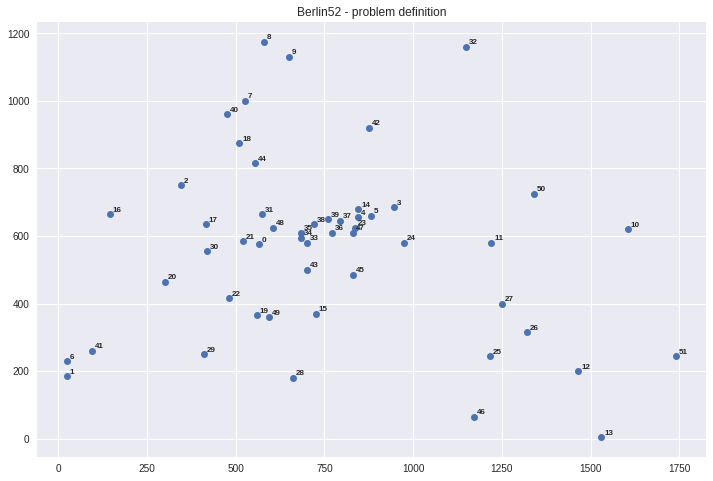

In [4]:
plt.figure(figsize=(12,8))

plt.plot(coords[:, 0], coords[:, 1], 'o')

for i in range(n):
    plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

plt.title('Berlin52 - problem definition')

plt.show()

<Figure size 864x576 with 0 Axes>

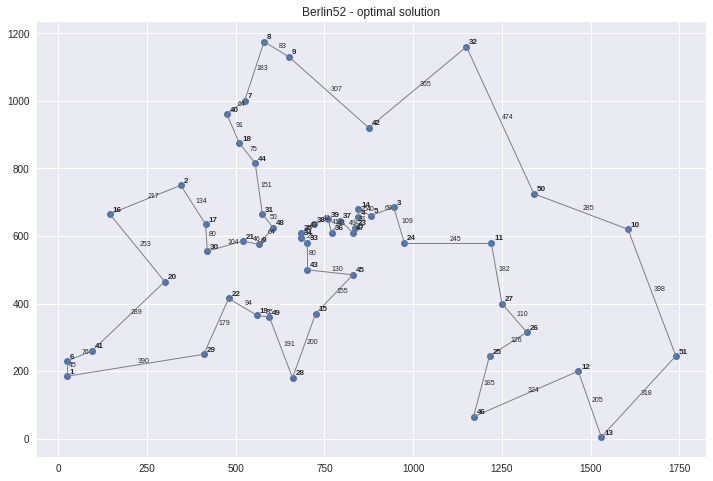

In [5]:
from matplotlib.lines import Line2D

route = p

plt.figure(figsize=(12,8))
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(coords[:, 0], coords[:, 1], 'o')

for i in range(n):
    plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

ax.add_line(Line2D(
    [coords[0, 0], coords[route[0], 0]],
    [coords[0, 1], coords[route[0], 1]],
    linewidth=1, color='gray'))
plt.text((coords[0, 0] + coords[route[0], 0])/2 + 6,
         (coords[0, 1] + coords[route[0], 1])/2 + 6,
         '%d' % A[0, route[0]], fontdict={'weight':'normal', 'size':7})
for i in range(1, len(route)):
    ax.add_line(Line2D(
        [coords[route[i-1], 0], coords[route[i], 0]],
        [coords[route[i-1], 1], coords[route[i], 1]],
        linewidth=1, color='gray'))
    plt.text((coords[route[i-1], 0] + coords[route[i], 0])/2 + 6,
             (coords[route[i-1], 1] + coords[route[i], 1])/2 + 6,
             '%d' % A[route[i-1], route[i]], fontdict={'weight':'normal', 'size':7})
ax.add_line(Line2D(
    [coords[route[-1], 0], coords[0, 0]],
    [coords[route[-1], 1], coords[0, 1]],
    linewidth=1, color='gray'))
plt.text((coords[route[-1], 0] + coords[0, 0])/2 + 6,
         (coords[route[-1], 1] + coords[0, 1])/2 + 6,
         '%d' % A[route[-1], 0], fontdict={'weight':'normal', 'size':7})

plt.title('Berlin52 - optimal solution')

plt.show()

## Objective function

In [0]:
def tsp_objective_function(A, perm):
    s = 0.0
    for i in range(n):
        s += A[perm[i-1], perm[i]]
    return s

In [7]:
print(tsp_objective_function(A, p), p)

7544.365901904086 [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21]


## Random Sampling

In [8]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = tsp_objective_function(A, permutations[i, :])

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(tsp_objective_function(A, p), p)

36.03037405014038
21719.105928041176 [16 17 26 13  0 22 37 34  5 12 11 42  7 40 15 14 24 48  6 41  1 51 10 50
 38 21 18 29 28 39 47 19 20 49 27 36  4 32  3 46 25 23  9 30 44 35 33 31
 45 43  2  8]


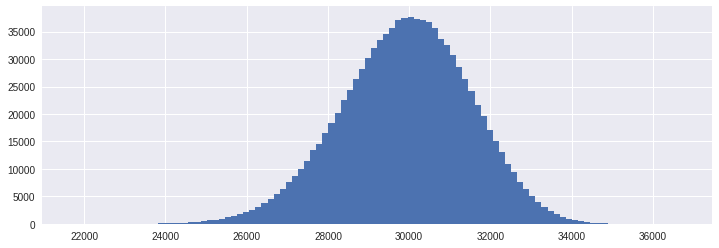

21719.105928041176 29912.15855962846 1578.497311926382


In [9]:
plt.figure(figsize=(12,4))
plt.hist(costs, bins=100)
plt.show()

print(costs.min(), costs.mean(), costs.std())

## Simulated Annealing

In [0]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [11]:
T = 500000
radius = 1
alpha = 1.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = tsp_objective_function(A, p)
costs = np.zeros(T)
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = tsp_objective_function(A, q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
    costs[t] = p_cost

print(time.time() - t0, costs.min())

37.8222439289093 8825.146596485181


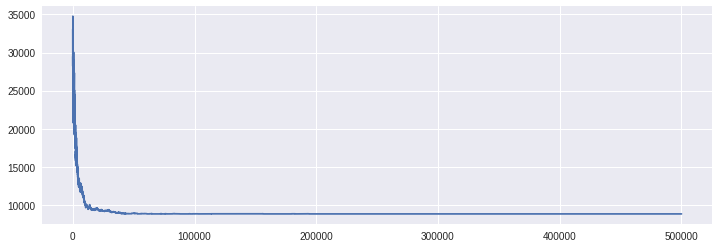

In [12]:
plt.figure(figsize=(12,4))
plt.plot(costs)
plt.show()

## SGA-PMX

### Crossovers

In [0]:
def _pmx(p1, p2, i, j):
    n = len(p1)

    c = np.full(n, -1)
    c[i:j+1] = p1[i:j+1]

    def find_place(k):
        if k < i or k > j:
            return k
        candidate, = np.where(p2 == p1[k])
        return find_place(candidate)

    for k, el in enumerate(p2[i:j+1], i):
        if el not in c:
            place = find_place(k)
            c[place] = el

    for k, el in enumerate(c):
        if el == -1:
            c[k] = p2[k]

    return c


def _ox(p1, p2, i, j):
    n = len(p1)

    c = np.full(n, -1)
    c[i:j+1] = p1[i:j+1]

    parent_values = list(filter(lambda x: x not in c[i:j+1], np.append(p2[j+1:], p2[:j+1])))
    end_count = (n-(j+1))
    c[j+1:] = parent_values[:end_count]
    c[:i] = parent_values[end_count:]

    return c


def _ex(p1, p2):
    n = len(p1)
    c = np.full(n, -1)
    edges_count = lambda i, p: Counter({int(p[i-1]): 1, int(p[(i+1)%n]): 1})
    edge_table = {
        x: dict(edges_count(i, p1) + edges_count(np.where(p2 == x)[0], p2))
        for i, x in enumerate(p1)
    }

    c[0] = np.random.choice(p1)
    for i, w in enumerate(c[:n-1]):
        es = edge_table.pop(w)
        edge_table = {k: [v.pop(w,0), v][1] for k, v in edge_table.items()}
        r = {0 if v == 2 else len(edge_table[k]): k for k, v in es.items()}
        new_el = r[min(r)] if r else np.random.choice(list(edge_table.keys()))
        c[i+1] = new_el

    return c


def random_partition(n):
    a = np.random.choice(n, 2, False)
    return a.min(), a.max()  # partition range


def pmx_crossover(p1, p2):
    i, j = random_partition(len(p1))
    return _pmx(p1, p2, i, j), _pmx(p2, p1, i, j)


def ox_crossover(p1, p2):
    i, j = random_partition(len(p1))
    return _ox(p1, p2, i, j), _ox(p2, p1, i, j)


def ex_crossover(p1, p2):
    # Edge recombination operator, D. Whitley
    return _ex(p1, p2), _ex(p1, p2)


### Mutations

In [0]:
def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q


def throas_mutation(k, p):
    i = np.random.choice(len(p)-k)
    q = p.copy()
    q[i:k+1] = q[i:k+1][::-1]
    return q


def scramble_mutation(k, p):
    q = p.copy()
    ss = np.random.choice(len(p), k, replace=False)

    if k == 2:
        q[ss[0]], q[ss[1]] = p[ss[1]], p[ss[0]]
        return q

    new_pos = np.random.choice(ss, k, replace=False)
    for s, pos in zip(ss, new_pos):
        q[pos] = p[s]
    return q

two_scramble_mutation = partial(scramble_mutation, 2)

### Plot

In [0]:
def relative_error(x, x0):
    return np.abs(x - x0) / x


def absolute_error(x, x0):
    return np.abs(x - x0)


def plot_sga_results(problem_name, **data):
    figsize = (12, 4)
    costs = data['costs']
    min_cost = data['best_value']

    print(f'Min cost: {min_cost}')
    print(f'OPT cost: {opts[problem_name]}')
    print(f'Relative error: {round(relative_error(opts[problem_name], min_cost)*100, 2)}%')
    print(f'Absolute error: {round(absolute_error(opts[problem_name], min_cost), 2)}')

    print(f'costs mean: {costs.mean()}')
    print(f'costs std: {costs.std()}')

    plt.figure(figsize=figsize, dpi=80)
    plt.title('Results')
    plt.plot(costs)


### SGA logic

In [0]:
def gen_initial_population(size, chromosome_len):
    current_population = np.zeros((size, chromosome_len), dtype=np.int64)
    for i in range(size):
        current_population[i, :] = np.random.permutation(chromosome_len)
    return current_population


def eval_obj_function(A, population, size):
    objective_values = np.zeros(size)
    for i in range(size):
        objective_values[i] = tsp_objective_function(A, population[i, :])
    return objective_values


def mutation(mutation_func, population, size, probability):
    for i in range(size):
        if np.random.random() < probability:
            population[i, :] = mutation_func(population[i, :])


def mu_plus_lambda_replacement(population, children_population,
                               objective_vals, children_objective_vals, population_size):
    objective_vals = np.hstack([objective_vals, children_objective_vals])
    population = np.vstack([population, children_population])

    I = np.argsort(objective_vals)
    population = population[I[:population_size], :]
    objective_vals = objective_vals[I[:population_size]]
    return population, objective_vals


def roulette_wheel_parent_indicies(objective_values, population_size, number_of_offspring):
    fitness_values = objective_values.max() - objective_values
    if fitness_values.sum() > 0:
        fitness_values = fitness_values / fitness_values.sum()
    else:
        fitness_values = np.ones(population_size) / population_size
    return np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)


def create_children_population(population, parent_indices, number_of_offspring,
                               chromosome_length, crossover_operator, crossover_probability):
    children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
    for i in range(int(number_of_offspring/2)):
        if np.random.random() < crossover_probability:
            children_population[2*i, :], children_population[2*i+1, :] = \
                crossover_operator(population[parent_indices[2*i], :].copy(),
                                   population[parent_indices[2*i+1], :].copy())
        else:
            children_population[2*i, :], children_population[2*i+1, :] = \
                population[parent_indices[2*i], :].copy(), population[parent_indices[2*i+1]].copy()
    if np.mod(number_of_offspring, 2) == 1:
        children_population[-1, :] = population[parent_indices[-1], :]
    return children_population

crossover_operator = pmx_crossover
mutation_operator = reverse_sequence_mutation

In [0]:
def sga(T,
        distance_matrix,
        crossover_operator,
        mutation_operator,
        population_size,
        chromosome_length,
        crossover_probability,
        mutation_probability):

    costs = np.zeros(T)
    
    number_of_offspring = population_size
    best_objective_value = np.Inf
    best_chromosome = np.zeros((1, chromosome_length))

    current_population = gen_initial_population(population_size, chromosome_length)
    objective_values = eval_obj_function(distance_matrix, current_population, population_size)

    time0 = time.time()

    for t in range(T):
        parent_indices = roulette_wheel_parent_indicies(objective_values, population_size, number_of_offspring)

        children_population = create_children_population(current_population, parent_indices,
                                                         number_of_offspring, chromosome_length,
                                                         crossover_operator, crossover_probability)

        mutation(mutation_operator, children_population, number_of_offspring, mutation_probability)

        children_objective_values = eval_obj_function(distance_matrix, children_population, number_of_offspring)

        current_population, objective_values = mu_plus_lambda_replacement(current_population, children_population,
                                                                          objective_values,
                                                                          children_objective_values,
                                                                          population_size)
        if objective_values[0] < best_objective_value:
            best_objective_value = objective_values[0]
            best_chromosome = current_population[0, :]

        costs[t] = objective_values[0]

        if not t % (T/10) or t == T-1:
            print('%3d %14.8f min: %12.8f mean: %12.8f max: %12.8f std: %12.8f' % (
                    t, time.time() - time0,
                    objective_values.min(), objective_values.mean(),
                    objective_values.max(), objective_values.std())
                 )
            
    return {
        'costs': costs,
        'best_value': best_objective_value,
        'best_chromosome': best_chromosome,
    }

  0     0.03265333 min: 24587.73370157 mean: 28281.87868156 max: 29729.03538850 std: 1064.15793812
 20     0.55240703 min: 18486.80422965 mean: 19290.27261647 max: 19529.99607807 std: 197.00198229
 40     1.08426666 min: 14434.45910668 mean: 14854.07227615 max: 15046.67355800 std: 101.73193311
 60     1.61029649 min: 11362.98536829 mean: 11536.74685327 max: 11686.30755916 std:  62.82861241
 80     2.14428520 min: 10233.43559760 mean: 10333.33556082 max: 10376.00263094 std:  36.66545325
100     2.66949129 min: 9352.63771469 mean: 9388.54843173 max: 9413.56865180 std:  18.88393569
120     3.22295451 min: 8943.33375176 mean: 9018.75286472 max: 9072.45462681 std:  52.88248974
140     3.74713898 min: 8547.63874017 mean: 8547.63874017 max: 8547.63874017 std:   0.00000000
160     4.27614355 min: 8450.58290424 mean: 8450.58290424 max: 8450.58290424 std:   0.00000000
180     4.79245758 min: 8450.58290424 mean: 8450.58290424 max: 8450.58290424 std:   0.00000000
199     5.29843903 min: 8450.58290

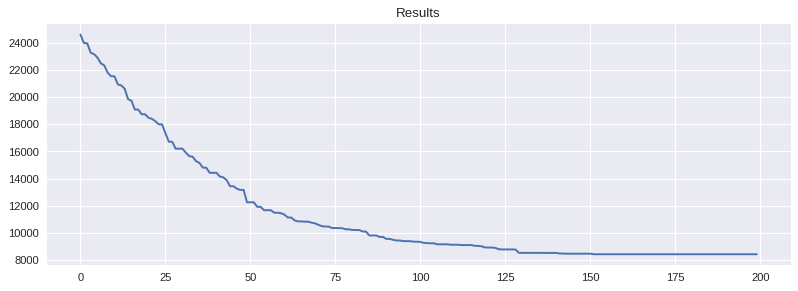

In [18]:
# Berlin52 - reverse_sequence_mutation and identity function as crossover

global problem_name
problem_name = 'berlin52'
params = {
    'T': 200,
    'population_size': 700,
    'chromosome_length': 52,
    'crossover_probability': 0.95,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': lambda x, y: (x, y),
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     0.18176460 min: 23094.74915836 mean: 28381.49902042 max: 29792.34150884 std: 1104.33163334
 20     3.77621222 min: 16006.97259320 mean: 18381.66389033 max: 18929.50013230 std: 470.54273972
 40     6.81659651 min: 11805.18132284 mean: 13139.17272335 max: 13447.16292834 std: 254.10876263
 60     9.42319226 min: 10066.19956132 mean: 10279.76826428 max: 10360.22754348 std:  60.41574358
 80    11.87450457 min: 9037.20935414 mean: 9145.34152750 max: 9194.24762204 std:  45.58230710
100    14.29732275 min: 8514.36702791 mean: 8671.78116974 max: 8688.14324084 std:  23.59781839
120    16.61140370 min: 8265.45622065 mean: 8265.45622065 max: 8265.45622065 std:   0.00000000
140    18.84371376 min: 8265.45622065 mean: 8265.45622065 max: 8265.45622065 std:   0.00000000
160    21.07938266 min: 8265.45622065 mean: 8265.45622065 max: 8265.45622065 std:   0.00000000
180    23.31711602 min: 8265.45622065 mean: 8265.45622065 max: 8265.45622065 std:   0.00000000
199    25.47046161 min: 8265.45622065

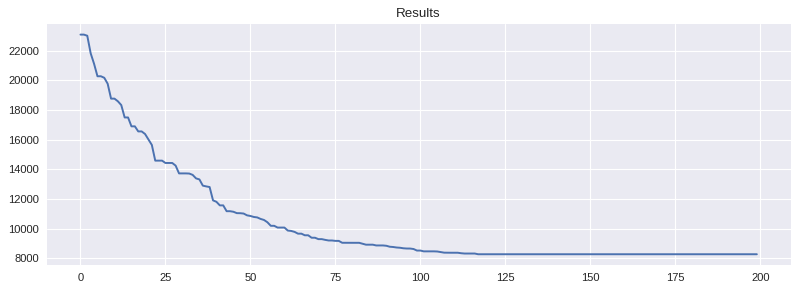

In [19]:
# Berlin52 - PMX as crossover and reverse_sequence_mutation
n = 52
A, _, _ = load_berlin52(n)
global problem_name
problem_name = 'berlin52'
params = {
    'T': 200,
    'population_size': 700,
    'chromosome_length': 52,
    'crossover_probability': 0.95,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': pmx_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     0.17998099 min: 23923.36782932 mean: 28453.88684394 max: 29848.14073833 std: 1071.69682394
 20     3.31628942 min: 15691.43089529 mean: 17656.13680968 max: 18096.36066724 std: 339.44499813
 40     5.71321821 min: 12940.13762763 mean: 13279.68444169 max: 13369.33487165 std: 103.91137379
 60     7.99936795 min: 11114.35454983 mean: 11343.32150178 max: 11400.30999697 std:  57.93036722
 80    10.23816109 min: 10673.37434491 mean: 10673.73134052 max: 10675.88762493 std:   0.77923230
100    12.41801167 min: 10393.32018009 mean: 10393.32018009 max: 10393.32018009 std:   0.00000000
120    14.57827020 min: 10393.32018009 mean: 10393.32018009 max: 10393.32018009 std:   0.00000000
140    16.70674944 min: 10393.32018009 mean: 10393.32018009 max: 10393.32018009 std:   0.00000000
160    18.89872766 min: 10370.85326114 mean: 10370.85326114 max: 10370.85326114 std:   0.00000000
180    21.06037402 min: 10370.85326114 mean: 10370.85326114 max: 10370.85326114 std:   0.00000000
199    23.11807489 

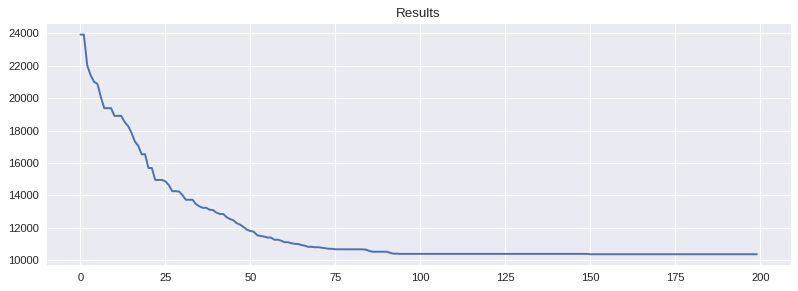

In [20]:
# Berlin52 - PMX and scramble mutation
n = 52
A, _, _ = load_berlin52(n)
global problem_name
problem_name = 'berlin52'
params = {
    'T': 200,
    'population_size': 700,
    'chromosome_length': 52,
    'crossover_probability': 0.95,
    'mutation_probability': 0.15,
    'distance_matrix': A,
    'crossover_operator': pmx_crossover,
    'mutation_operator': partial(scramble_mutation, 2),    
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     0.21496940 min: 24852.53317619 mean: 28486.20592565 max: 29798.70713196 std: 1038.01779099
 20     4.53315735 min: 15830.37045156 mean: 17563.35760812 max: 18080.23663174 std: 412.03052057
 40     8.88309407 min: 12110.09495524 mean: 13283.74252952 max: 13678.11473456 std: 322.05190536
 60    13.25091076 min: 10122.06126456 mean: 10565.55285087 max: 10627.32327564 std:  87.37057710
 80    17.59845400 min: 8674.29193858 mean: 9115.94754724 max: 9198.43222731 std:  93.33893854
100    21.91490459 min: 8255.16996966 mean: 8358.09255718 max: 8368.55065232 std:   9.03751225
120    26.24552536 min: 8056.31388301 mean: 8063.27962417 max: 8084.33697964 std:  12.11115551
140    30.66058087 min: 8056.31388301 mean: 8056.31388301 max: 8056.31388301 std:   0.00000000
160    35.04263401 min: 8056.31388301 mean: 8056.31388301 max: 8056.31388301 std:   0.00000000
180    39.39327717 min: 8056.31388301 mean: 8056.31388301 max: 8056.31388301 std:   0.00000000
199    43.55209064 min: 8056.31388301

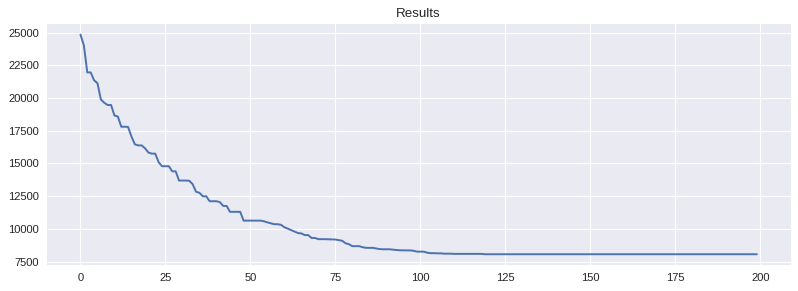

In [21]:
# Berlin52 - OX as crossover and reverse_sequence_mutation

global problem_name
problem_name = 'berlin52'
params = {
    'T': 200,
    'population_size': 700,
    'chromosome_length': 52,
    'crossover_probability': 0.90,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': ox_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     1.30954623 min: 24585.90391540 mean: 28422.84808433 max: 29663.42587490 std: 974.78763682
 15    20.41773796 min: 12502.28482654 mean: 14656.15171164 max: 15353.38150687 std: 585.13963522
 30    39.38741946 min: 9148.28409099 mean: 10094.58812079 max: 10460.41037855 std: 265.78367786
 45    57.55355835 min: 8438.64125582 mean: 8807.31697490 max: 8866.79025219 std:  54.41712914
 60    75.63994551 min: 8200.50093960 mean: 8203.34981667 max: 8203.35389232 std:   0.10775443
 75    93.40536356 min: 7775.92599489 mean: 7895.49549699 max: 7895.66655494 std:   4.52253392
 90   111.22441053 min: 7735.61657788 mean: 7735.61657788 max: 7735.61657788 std:   0.00000000
105   129.34155846 min: 7721.54086207 mean: 7721.54086207 max: 7721.54086207 std:   0.00000000
120   146.94489741 min: 7721.54086207 mean: 7721.54086207 max: 7721.54086207 std:   0.00000000
135   164.52831936 min: 7721.54086207 mean: 7721.54086207 max: 7721.54086207 std:   0.00000000
149   180.84790230 min: 7721.54086207 mean

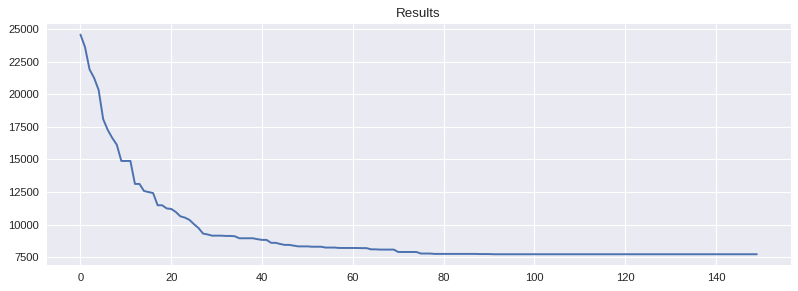

In [22]:
# Berlin52 - EX as crossover and reverse_sequence_mutation
n = 52
A, _, _ = load_berlin52(n)
global problem_name
problem_name = 'berlin52'
params = {
    'T': 150,
    'population_size': 700,
    'chromosome_length': 52,
    'crossover_probability': 0.95,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': ex_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     1.26284051 min: 23758.89100458 mean: 28530.23554692 max: 29883.62875197 std: 1052.15342952
 15    20.50179029 min: 13530.35989289 mean: 15283.11683518 max: 15854.92844733 std: 458.90553373
 30    39.06235361 min: 10249.70955855 mean: 10732.78185545 max: 11000.38669415 std: 188.92407614
 45    57.25042272 min: 9436.65629325 mean: 9552.44803485 max: 9699.60241879 std:  74.38586527
 60    74.98065138 min: 8777.26826291 mean: 8809.14793274 max: 8906.67785022 std:  55.65505906
 75    92.63868141 min: 8561.42073137 mean: 8561.42073137 max: 8561.42073137 std:   0.00000000
 90   110.51576018 min: 8561.42073137 mean: 8561.42073137 max: 8561.42073137 std:   0.00000000
105   128.28527474 min: 8561.42073137 mean: 8561.42073137 max: 8561.42073137 std:   0.00000000
120   146.28181624 min: 8561.42073137 mean: 8561.42073137 max: 8561.42073137 std:   0.00000000
135   164.18107700 min: 8561.42073137 mean: 8561.42073137 max: 8561.42073137 std:   0.00000000
149   180.33812046 min: 8561.42073137 me

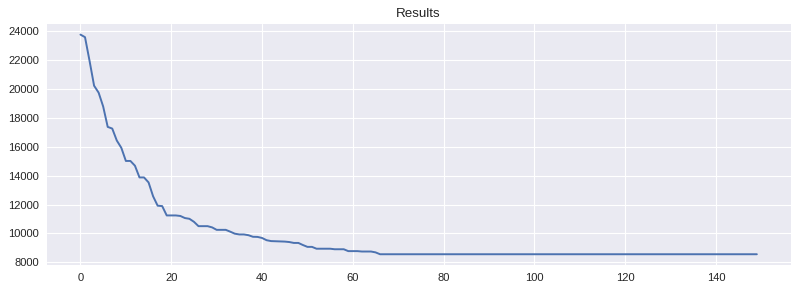

In [24]:
# Berlin52 - EX as crossover and scramble mutation
n = 52
A, _, _ = load_berlin52(n)
global problem_name
problem_name = 'berlin52'
params = {
    'T': 150,
    'population_size': 700,
    'chromosome_length': 52,
    'crossover_probability': 0.95,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': ex_crossover,
    'mutation_operator': partial(scramble_mutation, 2),    
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     1.24736166 min: 24864.88314389 mean: 28486.10675341 max: 29838.54180921 std: 952.50410119
 15    19.57201910 min: 14024.94044975 mean: 16789.15363471 max: 17415.64348534 std: 552.66253358
 30    38.34086156 min: 10577.91156458 mean: 12130.20806744 max: 12615.08170428 std: 440.32769917
 45    56.64497423 min: 9851.40825480 mean: 10125.81100554 max: 10170.15737501 std:  63.65308702
 60    74.56915021 min: 9262.42442105 mean: 9482.63073281 max: 9562.37870676 std:  95.12419991
 75    92.44360137 min: 8659.05591156 mean: 8809.33284230 max: 8884.59720457 std:  62.21221979
 90   110.16997266 min: 8391.98960857 mean: 8480.11271887 max: 8537.54310675 std:  37.54926660
105   127.99625015 min: 8113.18303670 mean: 8130.21344059 max: 8130.27375149 std:   0.93189259
120   145.46552420 min: 7869.29810500 mean: 7888.09317202 max: 7897.85517096 std:  13.43081707
135   163.14499378 min: 7793.59011131 mean: 7834.24679986 max: 7834.42843096 std:   2.67304522
149   179.56505799 min: 7788.66699384 m

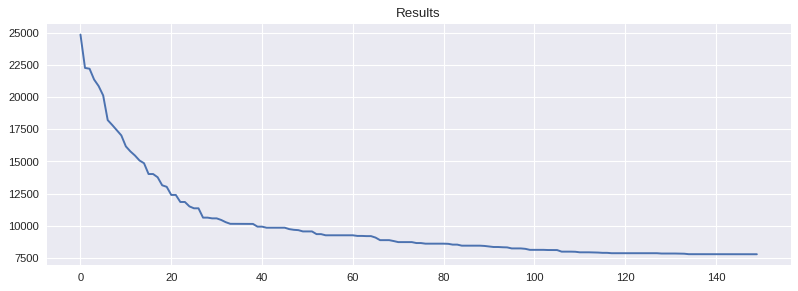

In [25]:
# Berlin52 - OX o EX as crossover and reverse_sequence_mutation
# Best result
n = 52
A, _, _ = load_berlin52(n)
global problem_name
problem_name = 'berlin52'
params = {
    'T': 150,
    'population_size': 700,
    'chromosome_length': 52,
    'crossover_probability': 0.80,
    'mutation_probability': 0.30,
    'distance_matrix': A,
    'crossover_operator': compose(ox_crossover, ex_crossover),
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     1.73245907 min: 24408.53759428 mean: 28321.17910391 max: 29688.03876078 std: 1049.14512544
 15    26.99531722 min: 12373.63045100 mean: 14378.71700705 max: 14975.17638831 std: 475.04822454
 30    51.91075110 min: 9008.70522990 mean: 9833.85529364 max: 10039.88416686 std: 162.36029302
 45    76.18423891 min: 8236.84513218 mean: 8418.14234448 max: 8488.36776876 std:  48.39658518
 60   100.32265544 min: 8066.80567056 mean: 8073.26294303 max: 8090.16864461 std:   2.62208343
 75   123.69630790 min: 7966.34878017 mean: 7966.34878017 max: 7966.34878017 std:   0.00000000
 90   147.29992127 min: 7966.34878017 mean: 7966.34878017 max: 7966.34878017 std:   0.00000000
105   171.25115919 min: 7963.95248568 mean: 7963.95248568 max: 7963.95248568 std:   0.00000000
120   194.64374447 min: 7963.95248568 mean: 7963.95248568 max: 7963.95248568 std:   0.00000000
135   218.07858086 min: 7963.95248568 mean: 7963.95248568 max: 7963.95248568 std:   0.00000000
149   239.98226643 min: 7963.95248568 mean

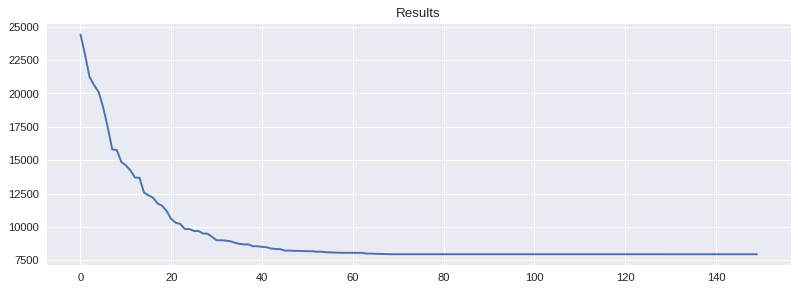

In [26]:
# Berlin52 - EX as crossover and throas_mutation 2
n = 52
A, _, _ = load_berlin52(n)
global problem_name
problem_name = 'berlin52'
params = {
    'T': 150,
    'population_size': 1000,
    'chromosome_length': 52,
    'crossover_probability': 0.90,
    'mutation_probability': 0.35,
    'distance_matrix': A,
    'crossover_operator': ex_crossover,
    'mutation_operator': partial(throas_mutation, 2),
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     1.17720604 min: 24166.29370976 mean: 28357.04803027 max: 29697.75119638 std: 1035.87851864
 20    24.85314941 min: 11016.25687377 mean: 12295.36468843 max: 12669.94569537 std: 290.71055705
 40    47.36703730 min: 8470.70341049 mean: 8618.19719913 max: 8651.97858573 std:  37.41047991
 60    69.26120043 min: 8350.96446459 mean: 8350.96446459 max: 8350.96446459 std:   0.00000000
 80    91.66995478 min: 8271.18449073 mean: 8271.18449073 max: 8271.18449073 std:   0.00000000
100   113.85802150 min: 8271.18449073 mean: 8271.18449073 max: 8271.18449073 std:   0.00000000
120   135.76721144 min: 8271.18449073 mean: 8271.18449073 max: 8271.18449073 std:   0.00000000
140   157.74000573 min: 8271.18449073 mean: 8271.18449073 max: 8271.18449073 std:   0.00000000
160   179.98936844 min: 8271.18449073 mean: 8271.18449073 max: 8271.18449073 std:   0.00000000
180   202.11669755 min: 8271.18449073 mean: 8271.18449073 max: 8271.18449073 std:   0.00000000
199   222.87585330 min: 8271.18449073 mean:

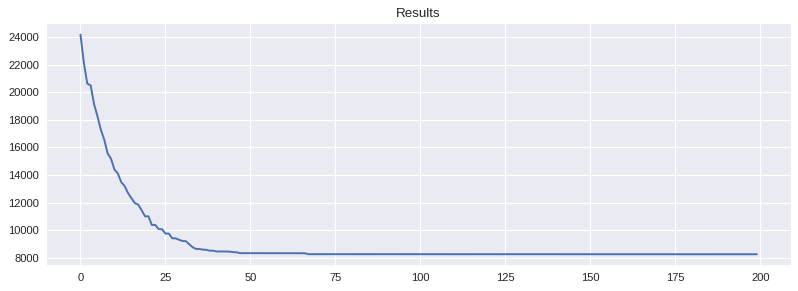

In [27]:
# Berlin52 - EX as crossover and throas_mutation 3
n = 52
A, _, _ = load_berlin52(n)
global problem_name
problem_name = 'berlin52'
params = {
    'T': 200,
    'population_size': 700,
    'chromosome_length': 52,
    'crossover_probability': 0.90,
    'mutation_probability': 0.35,
    'distance_matrix': A,
    'crossover_operator': ex_crossover,
    'mutation_operator': partial(throas_mutation, 3),    
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     0.45214868 min: 143314.45574230 mean: 163003.71723710 max: 169738.99859361 std: 4769.35918600
 30    13.88069034 min: 80418.13215037 mean: 90196.67484200 max: 92716.20282227 std: 2231.60571205
 60    27.46925116 min: 63688.90025070 mean: 67398.47667680 max: 68359.93009932 std: 778.51895821
 90    41.09058428 min: 51687.79017816 mean: 55528.48883529 max: 56614.73299226 std: 908.83304782
120    54.30400562 min: 44838.24866982 mean: 46148.43411559 max: 46654.40251687 std: 331.24964173
150    67.52682304 min: 39549.38909744 mean: 40761.57145711 max: 41317.24356995 std: 289.73181536
180    81.04386878 min: 34007.98856777 mean: 35180.07192852 max: 35577.28825261 std: 288.41253167
210    94.27520967 min: 29920.87994462 mean: 30362.72791228 max: 30463.28817609 std: 137.54575338
240   107.49333835 min: 27547.48994329 mean: 27583.76498113 max: 27628.45771085 std:   5.73191667
270   120.69692755 min: 25592.63939948 mean: 25723.34529720 max: 25761.74212690 std:  34.02921502
299   133.54886

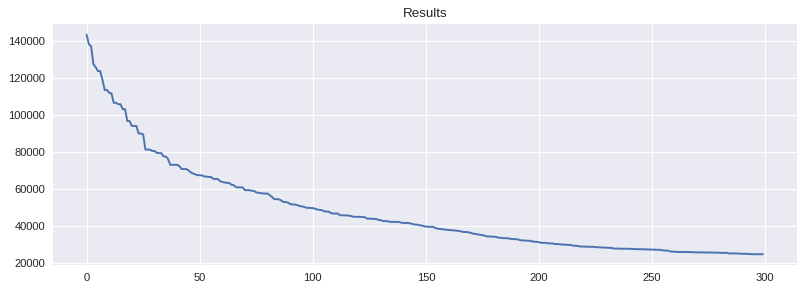

In [28]:
# kroa100 - OX as crossover and reverse_sequence_mutation
n = 100
A = load_kroa(n)
global problem_name
problem_name = f'kroA{n}'
params = {
    'T': 300,
    'population_size': 800,
    'chromosome_length': n,
    'crossover_probability': 0.95,
    'mutation_probability': 0.20,
    'distance_matrix': A,
    'crossover_operator': ox_crossover,
    'mutation_operator': reverse_sequence_mutation,
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     0.34854650 min: 138600.48131944 mean: 163070.69518393 max: 169803.63082022 std: 5286.56567849
 30     9.38213301 min: 91808.75341694 mean: 97742.06437750 max: 99311.51761947 std: 1315.63710692
 60    16.51006985 min: 64911.14691389 mean: 67260.59217960 max: 67706.44434231 std: 432.00125113
 90    23.07973862 min: 49828.83913807 mean: 51703.03046457 max: 52097.99244882 std: 464.84703532
120    29.61985397 min: 38287.89534222 mean: 39508.36891222 max: 39749.71200089 std: 308.62551848
150    35.79870200 min: 32282.57417910 mean: 33319.21456437 max: 33520.66132776 std: 156.97590447
180    41.99333525 min: 28190.34811090 mean: 28566.52139860 max: 28758.31410914 std: 113.02267460
210    48.07492828 min: 25368.37460711 mean: 25406.92700805 max: 25408.90275527 std:   8.72753110
240    54.02747536 min: 23513.46158474 mean: 23604.63015395 max: 23652.42027264 std:  15.67071375
270    59.89396143 min: 23137.46883576 mean: 23137.46883576 max: 23137.46883576 std:   0.00000000
299    65.68387

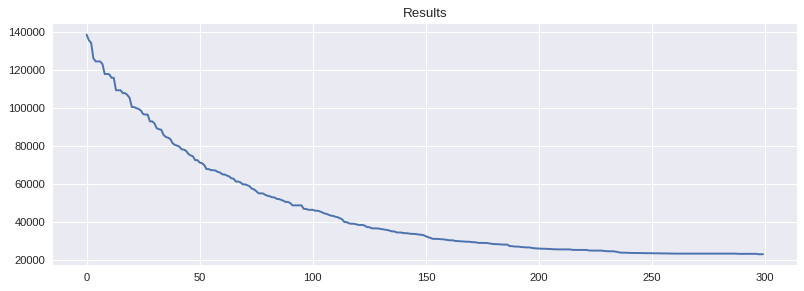

In [29]:
# kroa100 - PMX as crossover and reverse_sequence_mutation
# Best result
n = 100
A = load_kroa(n)
global problem_name
problem_name = f'kroA{n}'
params = {
    'T': 300,
    'population_size': 800,
    'chromosome_length': n,
    'crossover_probability': 0.95,
    'mutation_probability': 0.20,
    'distance_matrix': A,
    'crossover_operator': pmx_crossover,
    'mutation_operator': reverse_sequence_mutation,
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     2.94087625 min: 142316.06525080 mean: 163612.33416605 max: 169835.44333607 std: 4628.66638037
 30    92.53145981 min: 61734.02406406 mean: 67968.41903667 max: 69956.67824318 std: 1572.08887112
 60   179.63462257 min: 41075.68417737 mean: 42728.91711222 max: 42896.34034653 std: 235.95435589
 90   263.80446148 min: 36834.91766124 mean: 36859.58661368 max: 36859.64844063 std:   1.23499233
120   347.16822386 min: 35097.58417043 mean: 35166.26217353 max: 35337.17727335 std:  19.39019836
150   431.99164581 min: 33370.10199530 mean: 33370.10199530 max: 33370.10199530 std:   0.00000000
180   515.66370010 min: 32879.49146283 mean: 32879.49146283 max: 32879.49146283 std:   0.00000000
210   599.09727597 min: 32149.83795469 mean: 32474.75387950 max: 32475.16053272 std:  11.49469912
240   683.22830868 min: 32149.83795469 mean: 32149.83795469 max: 32149.83795469 std:   0.00000000
270   766.57368398 min: 32149.83795469 mean: 32149.83795469 max: 32149.83795469 std:   0.00000000
299   846.93923

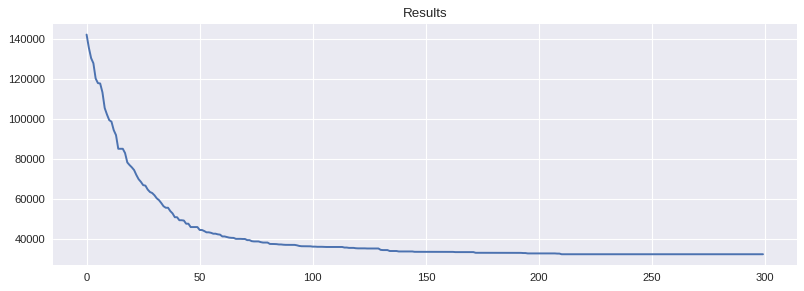

In [30]:
# kroa100 - EX as crossover and throas_mutation 4
n = 100
A = load_kroa(n)
global problem_name
problem_name = f'kroA{n}'
params = {
    'T': 300,
    'population_size': 800,
    'chromosome_length': n,
    'crossover_probability': 0.85,
    'mutation_probability': 0.35,
    'distance_matrix': A,
    'crossover_operator': ex_crossover,
    'mutation_operator':  partial(throas_mutation, 4),
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     3.05781746 min: 144206.40819460 mean: 162856.05439351 max: 169193.57662637 std: 4747.30015677
 15    47.53742361 min: 82052.00284930 mean: 94909.85021722 max: 98885.83515876 std: 3122.37240308
 30    91.53723431 min: 62877.41255775 mean: 68305.69388859 max: 70196.06657718 std: 1509.91761611
 45   135.11836028 min: 51072.06382033 mean: 55061.53517209 max: 56041.06656303 std: 776.06994794
 60   177.50955248 min: 45922.23645400 mean: 47483.12944054 max: 47531.52324445 std: 153.99398899
 75   219.82749677 min: 42005.13998014 mean: 42824.21652588 max: 42932.56048125 std: 121.58501639
 90   261.72250962 min: 38832.82829129 mean: 39399.48747604 max: 39432.24417016 std:  82.51213934
105   303.53371334 min: 35937.35786420 mean: 36752.61347630 max: 37044.47405240 std: 275.82778751
120   345.95162916 min: 33076.19772343 mean: 34253.68263642 max: 34356.52108118 std: 184.86797702
135   387.62946391 min: 31730.63614905 mean: 31912.54710660 max: 32118.94928885 std:  39.19099089
149   427.1213

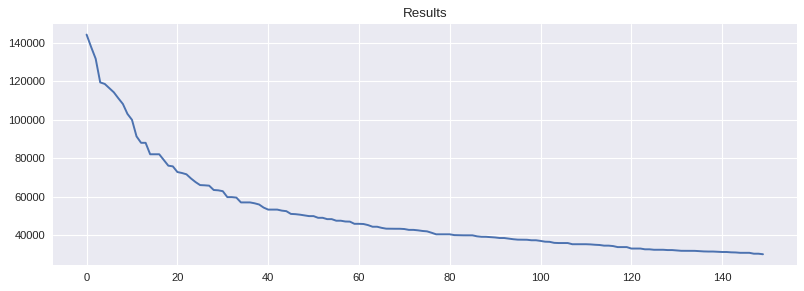

In [32]:
# kroa100 - EX as crossover and reverse_sequence_mutation
n = 100
A = load_kroa(n)
global problem_name
problem_name = f'kroA{n}'
params = {
    'T': 150,
    'population_size': 800,
    'chromosome_length': n,
    'crossover_probability': 0.85,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': ex_crossover,
    'mutation_operator': reverse_sequence_mutation,
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     3.18726969 min: 227278.90080117 mean: 247869.07799212 max: 256280.43013326 std: 6181.71888154
 15    50.38171220 min: 142461.83628486 mean: 162051.74849418 max: 166266.00456354 std: 3674.49595132
 30    96.65587592 min: 117488.26257339 mean: 124115.38724831 max: 125932.69784693 std: 1807.35144087
 45   142.40821457 min: 100713.42357658 mean: 104762.31233193 max: 106099.62495833 std: 1009.47457070
 60   187.49027729 min: 89555.91805279 mean: 92529.61248804 max: 92774.05282098 std: 405.97112561
 75   231.96197009 min: 81846.25745554 mean: 83113.45627598 max: 83739.97341880 std: 280.09201092
 90   276.02508521 min: 76444.55804971 mean: 77386.64292373 max: 77593.97041634 std: 288.53370333
105   321.01092052 min: 70532.57451476 mean: 71828.16241275 max: 72157.59184529 std: 259.97182522
120   365.27885342 min: 66171.74384573 mean: 67071.82863683 max: 67113.78908151 std: 113.10824653
135   409.20850563 min: 63879.92819073 mean: 64523.52080022 max: 64595.56500360 std:  90.33293529
149 

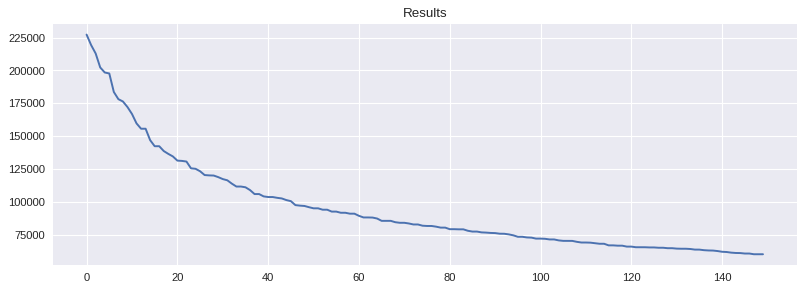

In [34]:
# kroa150 - EX as crossover and reverse_sequence_mutation
n = 150
A = kroa150_distance
global problem_name
problem_name = f'kroA{n}'
params = {
    'T': 150,
    'population_size': 500,
    'chromosome_length': n,
    'crossover_probability': 0.80,
    'mutation_probability': 0.30,
    'distance_matrix': A,
    'crossover_operator': ex_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)


plot_sga_results(problem_name, **results)

  0     0.44065738 min: 223555.73953767 mean: 248498.79133978 max: 256037.54550107 std: 5754.36566430
 30    13.33507371 min: 145835.89570566 mean: 155605.90029832 max: 158782.45358234 std: 2424.61613895
 60    26.36975908 min: 112956.92978895 mean: 118736.57749055 max: 121098.11457671 std: 1830.47886632
 90    39.37096214 min: 93505.29881104 mean: 96755.15343033 max: 97979.99775362 std: 868.17966955
120    52.35906911 min: 78291.96967735 mean: 80011.93495604 max: 80773.30753682 std: 422.27477818
150    65.20457840 min: 66390.30942884 mean: 68429.89890268 max: 68926.70941493 std: 425.95635380
180    78.53697801 min: 57280.99456137 mean: 58383.58131091 max: 58792.07673726 std: 429.89210894
210    91.61859751 min: 49564.65721728 mean: 50561.54453183 max: 50892.99132143 std: 223.27733636
240   104.64031625 min: 44851.98700842 mean: 45609.95034466 max: 45821.07998441 std: 194.99374302
270   117.46276593 min: 38630.02741003 mean: 39373.66835687 max: 39459.05949476 std: 113.51087292
299   13

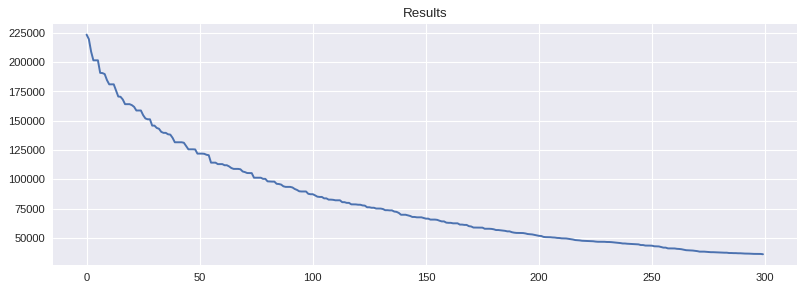

In [35]:
# kroa150 - OX as crossover and reverse_sequence_mutation
n = 150
A = kroa150_distance
global problem_name
problem_name = f'kroA{n}'
params = {
    'T': 300,
    'population_size': 600,
    'chromosome_length': n,
    'crossover_probability': 0.85,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': ox_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)


plot_sga_results(problem_name, **results)

  0     0.73435163 min: 220599.26166979 mean: 248032.01652739 max: 256703.51729597 std: 6408.98628767
 50    37.13121581 min: 124495.04796810 mean: 131440.80362200 max: 133503.38031702 std: 1716.90916938
100    73.42324162 min: 96624.40653391 mean: 100364.53587445 max: 101563.03996692 std: 881.67395036
150   110.26714826 min: 71982.40727673 mean: 75309.69483104 max: 76117.04043006 std: 738.32299793
200   146.36297297 min: 56782.82966759 mean: 58962.08327539 max: 59355.94136122 std: 486.56283205
250   182.31249833 min: 47513.70997137 mean: 48583.40346860 max: 48814.85839687 std: 238.75993837
300   218.46156549 min: 41195.43828641 mean: 41753.31980777 max: 41839.16186735 std: 101.89872408
350   255.30371785 min: 36016.30567835 mean: 36401.70011766 max: 36442.76694260 std:  47.65624929
400   291.26288176 min: 33104.70732368 mean: 33137.36703009 max: 33157.89996900 std:  25.89535393
450   327.65812445 min: 30529.22491047 mean: 30529.22491047 max: 30529.22491047 std:   0.00000000
499   363.

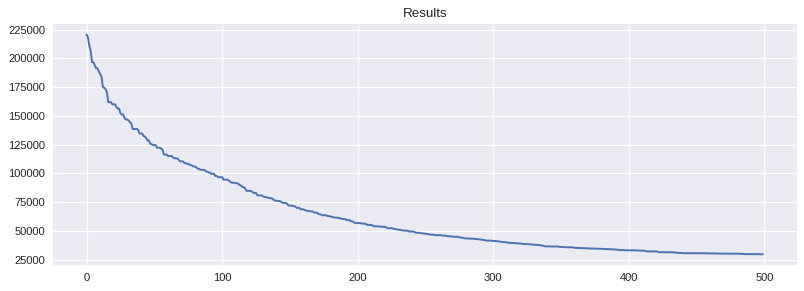

In [49]:
# kroa150 - OX as crossover and reverse_sequence_mutation
# Best result
n = 150
A = kroa150_distance
global problem_name
problem_name = f'kroA{n}'
params = {
    'T': 500,
    'population_size': 1000,
    'chromosome_length': n,
    'crossover_probability': 0.85,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': ox_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)


plot_sga_results(problem_name, **results)

  0     2.66098189 min: 217108.64431197 mean: 247484.91080318 max: 255417.44809604 std: 6057.31551033
 15    39.80300879 min: 163412.12451242 mean: 176676.44089898 max: 180137.20857079 std: 3069.75690531
 30    75.66899300 min: 134109.25203709 mean: 139172.76431501 max: 143170.69542780 std: 2366.63464235
 45   111.66615009 min: 122136.62341720 mean: 124808.23970677 max: 126412.56672767 std: 975.74354425
 60   146.89976239 min: 112938.83936332 mean: 116334.78040664 max: 117135.89717278 std: 744.89840819
 75   182.45262456 min: 101293.00910408 mean: 103018.55958493 max: 103727.60519789 std: 476.38761131
 90   217.55645084 min: 95137.24894062 mean: 97001.48550932 max: 97692.27598619 std: 402.39337807
105   251.77289462 min: 88005.89503614 mean: 91234.09465322 max: 92040.96495544 std: 606.76073442
120   288.23038816 min: 84353.38349269 mean: 86400.64815367 max: 86883.02803685 std: 353.94438682
135   324.11529303 min: 79214.12764090 mean: 80973.35578693 max: 81819.60795076 std: 676.54173730

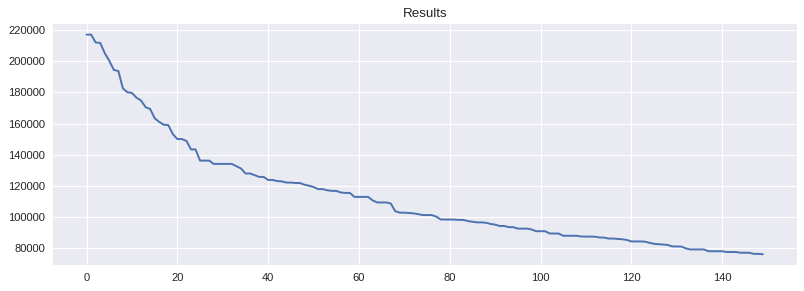

In [45]:
# kroa150 - OX o EX as crossover and reverse_sequence_mutation
n = 150
A = kroa150_distance
global problem_name
problem_name = f'kroA{n}'
params = {
    'T': 150,
    'population_size': 400,
    'chromosome_length': n,
    'crossover_probability': 0.70,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': compose(ox_crossover, ex_crossover),
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)


plot_sga_results(problem_name, **results)

  0     0.68419957 min: 301782.16473632 mean: 329368.40276989 max: 339078.30466533 std: 7429.27163104
 30    21.41293120 min: 218891.97449876 mean: 228834.21855833 max: 232780.43688844 std: 2882.91772592
 60    42.33654523 min: 169574.02850918 mean: 177476.80064457 max: 179581.42464841 std: 1735.03250245
 90    63.28632808 min: 144079.96587503 mean: 148109.46058712 max: 149213.97038740 std: 1023.24584732
120    83.98553681 min: 126388.66807529 mean: 128880.47555883 max: 129886.06483241 std: 788.84367352
150   104.90979886 min: 108366.78157417 mean: 113446.88336260 max: 114325.68866457 std: 806.34291141
180   125.72995090 min: 96644.13435954 mean: 99857.87789160 max: 100535.96704299 std: 612.89588190
210   146.39367557 min: 88508.88305138 mean: 90426.76335171 max: 91049.71502331 std: 499.85355664
240   166.85832119 min: 80613.06038688 mean: 82002.67011241 max: 82384.22128668 std: 352.68281164
270   187.30788517 min: 73924.39768458 mean: 75386.85458693 max: 75850.09567200 std: 341.444901

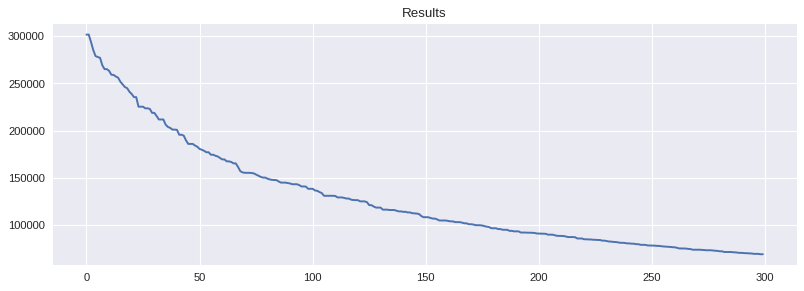

In [36]:
# kroa200 - OX as crossover and reverse_sequence_mutation
n = 200
A = load_kroa(n)
global problem_name
problem_name = f'kroA{n}'
params = {
    'T': 300,
    'population_size': 700,
    'chromosome_length': n,
    'crossover_probability': 0.90,
    'mutation_probability': 0.20,
    'distance_matrix': A,
    'crossover_operator': ox_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)


plot_sga_results(problem_name, **results)

  0     0.86965966 min: 300470.68826918 mean: 329798.61175608 max: 339345.49213567 std: 7025.33955816
 45    39.20314479 min: 183797.77638043 mean: 193595.92592000 max: 195589.52456583 std: 1891.23646631
 90    77.70297217 min: 139796.14436753 mean: 146704.67670280 max: 148548.83337371 std: 1610.28696838
135   115.99381638 min: 114212.34706357 mean: 117308.33123644 max: 118021.78942358 std: 544.06060878
180   154.29560494 min: 96746.38075119 mean: 98434.86585324 max: 99036.99977233 std: 387.15308100
225   192.27313805 min: 82448.73722227 mean: 84688.14036065 max: 85425.21594953 std: 553.12844928
270   230.46128774 min: 71172.42641774 mean: 72935.07043918 max: 73327.20120664 std: 329.26127819
315   268.63799596 min: 63951.51229849 mean: 64713.88509994 max: 64987.79846749 std: 206.54218681
360   307.11424041 min: 55535.51514494 mean: 56372.10937310 max: 56374.60464163 std:  31.94724327
405   345.69911981 min: 50967.68553450 mean: 51066.04014404 max: 51071.00909581 std:  17.25023738
449  

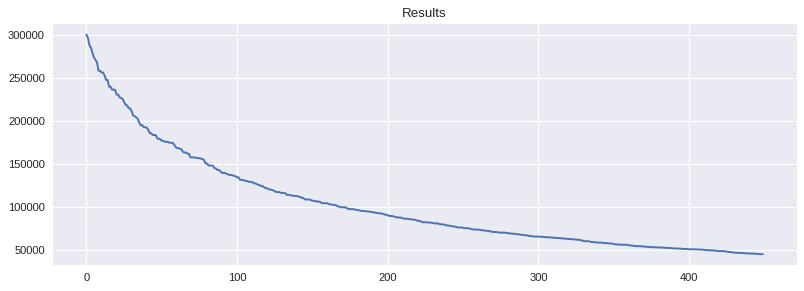

In [48]:
# kroa200 - OX as crossover and reverse_sequence_mutation
n = 200
A = load_kroa(n)
global problem_name
problem_name = f'kroA{n}'
params = {
    'T': 450,
    'population_size': 900,
    'chromosome_length': n,
    'crossover_probability': 0.85,
    'mutation_probability': 0.20,
    'distance_matrix': A,
    'crossover_operator': ox_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)


plot_sga_results(problem_name, **results)

  0     1.07136869 min: 299057.03636434 mean: 329471.90272913 max: 338222.99074135 std: 6878.58319115
 50    48.77791977 min: 175504.89405750 mean: 184463.81497064 max: 186801.58882147 std: 1840.38765565
100    96.20370841 min: 129232.29259388 mean: 134408.61833659 max: 136398.50163071 std: 1769.37738070
150   143.52164507 min: 102148.24629820 mean: 105229.93824948 max: 106049.61829283 std: 726.88466803
200   190.32099009 min: 87121.40124889 mean: 89714.24058290 max: 90323.46265404 std: 579.78976868
250   237.98734069 min: 75401.65199903 mean: 77528.18321990 max: 78113.52286593 std: 441.30489456
300   285.24379611 min: 66743.37668059 mean: 67401.88511667 max: 67622.14442422 std: 227.22301122
350   332.35289693 min: 60338.72281917 mean: 60985.51021323 max: 61166.15275250 std: 168.06015913
400   379.17935658 min: 52626.99238225 mean: 53162.05266601 max: 53318.19476013 std: 106.96847336
450   424.74723101 min: 48415.59209916 mean: 49320.00539560 max: 49411.74088546 std: 146.23038965
499  

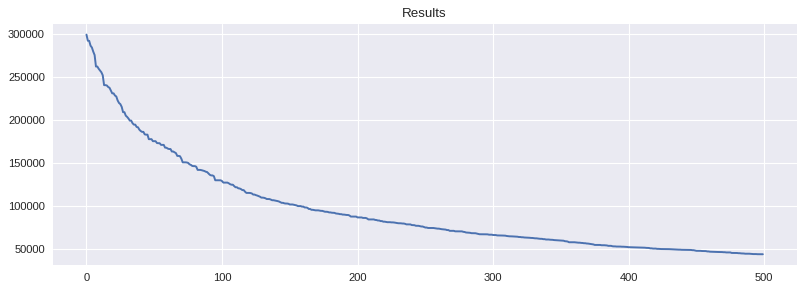

In [50]:
# kroa200 - OX as crossover and reverse_sequence_mutation
n = 200
A = load_kroa(n)
global problem_name
problem_name = f'kroA{n}'
params = {
    'T': 500,
    'population_size': 1000,
    'chromosome_length': n,
    'crossover_probability': 0.85,
    'mutation_probability': 0.20,
    'distance_matrix': A,
    'crossover_operator': ox_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)


plot_sga_results(problem_name, **results)

  0     1.14046741 min: 303982.48264337 mean: 329226.48072133 max: 338816.95374120 std: 6967.53872531
 60    67.30535626 min: 162356.62363269 mean: 171112.55941508 max: 173225.94084628 std: 1712.68554725
120   135.02992702 min: 120753.99521360 mean: 123804.14997689 max: 124659.10644984 std: 685.44325653
180   201.19138455 min: 94614.05518868 mean: 98541.56897124 max: 99567.10406294 std: 892.07642431
240   267.16353750 min: 77853.83224822 mean: 79289.58102872 max: 79407.97619592 std: 185.42295765
300   334.15890336 min: 66170.69807707 mean: 66985.78914719 max: 67222.31039143 std: 154.96019019
360   401.28441906 min: 55619.73032453 mean: 57309.85951249 max: 57744.60602826 std: 340.36986917
420   467.84083533 min: 47300.79512545 mean: 48339.48721022 max: 48505.26178484 std: 137.75957853
480   533.78880167 min: 39781.77515188 mean: 40174.92836413 max: 40278.40833361 std:  86.50935042
540   600.41217685 min: 35209.62849340 mean: 35469.05460597 max: 35644.35822708 std:  91.01475544
599   666

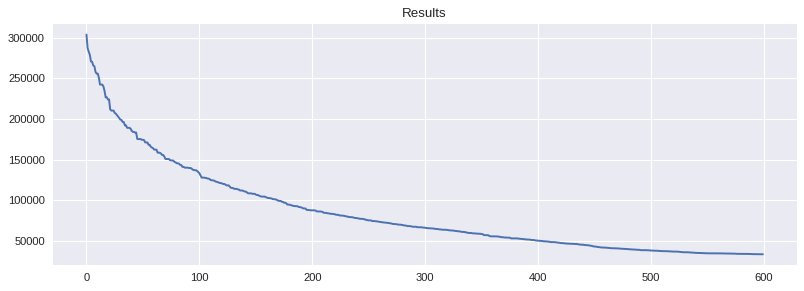

In [51]:
# kroa200 - OX as crossover and reverse_sequence_mutation
# Best result
n = 200
A = load_kroa(n)
global problem_name
problem_name = f'kroA{n}'
params = {
    'T': 600,
    'population_size': 1200,
    'chromosome_length': n,
    'crossover_probability': 0.85,
    'mutation_probability': 0.20,
    'distance_matrix': A,
    'crossover_operator': ox_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)


plot_sga_results(problem_name, **results)

  0     4.35946155 min: 303161.88034158 mean: 328925.88245984 max: 337751.15729516 std: 6460.45672590
 10    48.04267645 min: 227914.31354130 mean: 255874.76994712 max: 261946.51875922 std: 5192.99671936
 20    91.66778564 min: 194319.62613817 mean: 207902.36971719 max: 212210.81682765 std: 3479.46221050
 30   136.02118731 min: 166250.90853617 mean: 178365.86767343 max: 182024.30106591 std: 3167.48081727
 40   179.46414328 min: 141539.50318379 mean: 157564.32050000 max: 160961.26729100 std: 2777.19433070
 50   222.93967438 min: 128046.53817882 mean: 140762.77703802 max: 143264.62094792 std: 2334.64435735
 60   265.26631284 min: 118028.82869661 mean: 121753.30234120 max: 122300.74842927 std: 995.82905916
 70   306.63316655 min: 114265.37761266 mean: 115902.52637098 max: 116529.26678881 std: 534.82726593
 80   348.63332629 min: 109243.24972280 mean: 110142.15524418 max: 110153.32676799 std:  84.62969432
 90   389.86254263 min: 105729.42365107 mean: 107032.99765186 max: 107575.96368862 st

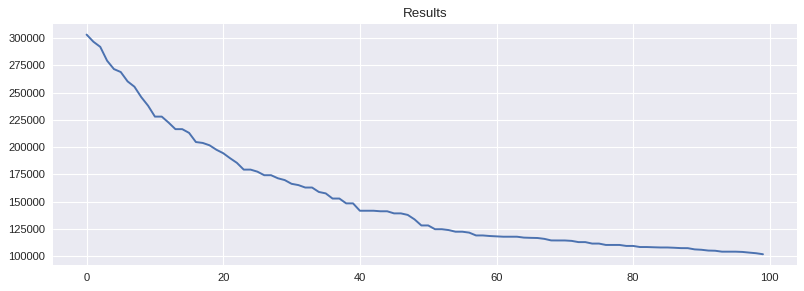

In [43]:
# kroa200 - EX as crossover and reverse_sequence_mutation
n = 200
A = load_kroa(n)
global problem_name
problem_name = f'kroA{n}'
params = {
    'T': 100,
    'population_size': 400,
    'chromosome_length': n,
    'crossover_probability': 0.90,
    'mutation_probability': 0.20,
    'distance_matrix': A,
    'crossover_operator': ex_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)


plot_sga_results(problem_name, **results)

  0     0.19603944 min: 4678.00000000 mean: 5561.43000000 max: 5882.00000000 std: 239.45283829
 20     4.24561882 min: 3054.00000000 mean: 3582.69333333 max: 3730.00000000 std: 101.20995976
 40     8.15390778 min: 2455.00000000 mean: 2754.23666667 max: 2843.00000000 std:  58.82817343
 60    11.87145734 min: 2144.00000000 mean: 2269.48166667 max: 2302.00000000 std:  38.03256934
 80    15.40241098 min: 2107.00000000 mean: 2107.00000000 max: 2107.00000000 std:   0.00000000
100    18.82530427 min: 2105.00000000 mean: 2105.00000000 max: 2105.00000000 std:   0.00000000
120    22.26133919 min: 2105.00000000 mean: 2105.00000000 max: 2105.00000000 std:   0.00000000
140    25.73885560 min: 2105.00000000 mean: 2105.00000000 max: 2105.00000000 std:   0.00000000
160    29.18153977 min: 2105.00000000 mean: 2105.00000000 max: 2105.00000000 std:   0.00000000
180    32.74398875 min: 2105.00000000 mean: 2105.00000000 max: 2105.00000000 std:   0.00000000
199    36.14418626 min: 2105.00000000 mean: 2105.0

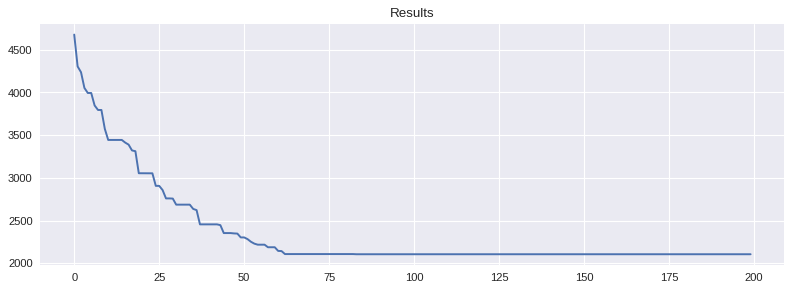

In [44]:
# bays29 - PMX o OX as crossover and reverse_sequence_mutation
n = 29
A = load_bays29()
global problem_name
problem_name = f'bays{n}'
params = {
    'T': 200,
    'population_size': 600,
    'chromosome_length': n,
    'crossover_probability': 0.90,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': compose(pmx_crossover, ox_crossover),
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)


plot_sga_results(problem_name, **results)

  0     0.52301335 min: 4586.00000000 mean: 5537.30166667 max: 5860.00000000 std: 255.78329499
 10     5.87031913 min: 2679.00000000 mean: 3125.76833333 max: 3296.00000000 std: 125.12759354
 20    11.09764791 min: 2145.00000000 mean: 2325.58833333 max: 2390.00000000 std:  54.31978336
 30    16.12000942 min: 2034.00000000 mean: 2040.79000000 max: 2041.00000000 std:   1.19411055
 40    21.12119961 min: 2034.00000000 mean: 2034.00000000 max: 2034.00000000 std:   0.00000000
 50    26.03469801 min: 2034.00000000 mean: 2034.00000000 max: 2034.00000000 std:   0.00000000
 60    30.99625635 min: 2034.00000000 mean: 2034.00000000 max: 2034.00000000 std:   0.00000000
 70    35.97546291 min: 2034.00000000 mean: 2034.00000000 max: 2034.00000000 std:   0.00000000
 80    40.95249271 min: 2034.00000000 mean: 2034.00000000 max: 2034.00000000 std:   0.00000000
 90    45.97873950 min: 2034.00000000 mean: 2034.00000000 max: 2034.00000000 std:   0.00000000
 99    50.40759778 min: 2034.00000000 mean: 2034.0

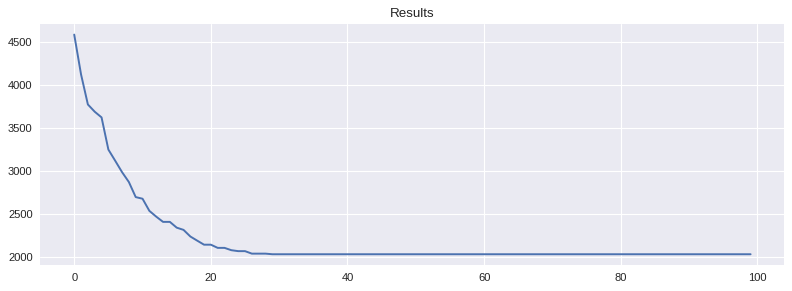

In [40]:
# bays29 - EX as crossover and reverse_sequence_mutation
# Best result
n = 29
A = load_bays29()
global problem_name
problem_name = f'bays{n}'
params = {
    'T': 100,
    'population_size': 600,
    'chromosome_length': n,
    'crossover_probability': 0.90,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': ex_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)


plot_sga_results(problem_name, **results)